In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

### Resolucion literal E

In [32]:
import pandas as pd
path = 'data/data.csv'
df = pd.read_csv(path, delimiter=';')
df.head()

,timestamp,V005_vent01_CO2,V022_vent02_CO2,V006_vent01_temp_out,V023_vent02_temp_out
0,23.06.2012 01:00,494.172532,405.514287,22.700000,23.449972
1,23.06.2012 02:00,491.992574,404.705170,22.700000,23.400000
2,23.06.2012 03:00,490.003467,401.981443,22.628444,23.400000
3,23.06.2012 04:00,490.972327,402.471192,22.600000,23.400000
4,23.06.2012 05:00,489.132106,403.174487,22.600000,23.349972


In [34]:
# Primero extraeré los patrones diarios a partir de la columna timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y %H:%M')
df['hour_of_day'] = df['timestamp'].dt.hour
# Agregar una columna que contenga el día de la semana
df['day_of_week'] = df['timestamp'].dt.day_name()

In [35]:
df.head()

,timestamp,V005_vent01_CO2,V022_vent02_CO2,V006_vent01_temp_out,V023_vent02_temp_out,hour_of_day,day_of_week
0,2012-06-23 01:00:00,494.172532,405.514287,22.700000,23.449972,1,Saturday
1,2012-06-23 02:00:00,491.992574,404.705170,22.700000,23.400000,2,Saturday
2,2012-06-23 03:00:00,490.003467,401.981443,22.628444,23.400000,3,Saturday
3,2012-06-23 04:00:00,490.972327,402.471192,22.600000,23.400000,4,Saturday
4,2012-06-23 05:00:00,489.132106,403.174487,22.600000,23.349972,5,Saturday


In [5]:
# Crear diagramas de caja (boxplots) por día de la semana
days_of_week = df['day_of_week'].unique()
variables = ['V005_vent01_CO2', 'V006_vent01_temp_out', 'V022_vent02_CO2', 'V023_vent02_temp_out']

### Identificacion de patrones por dia de la semana por hora

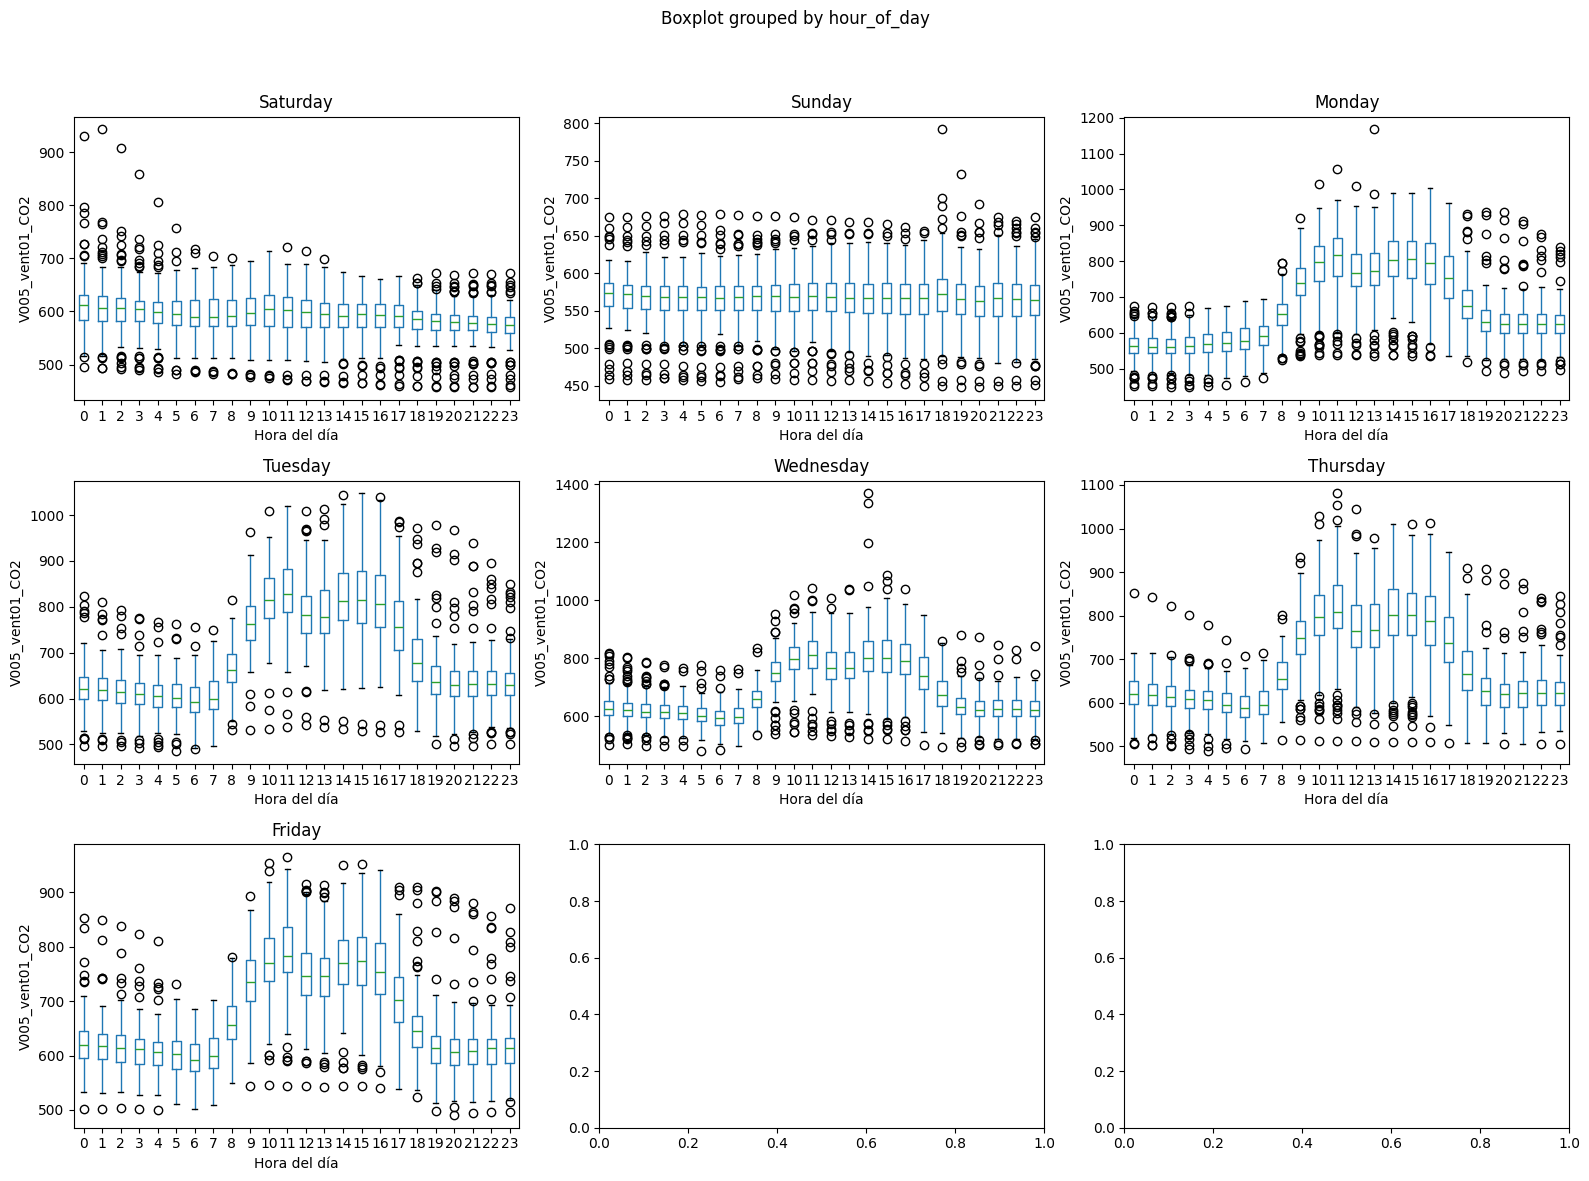

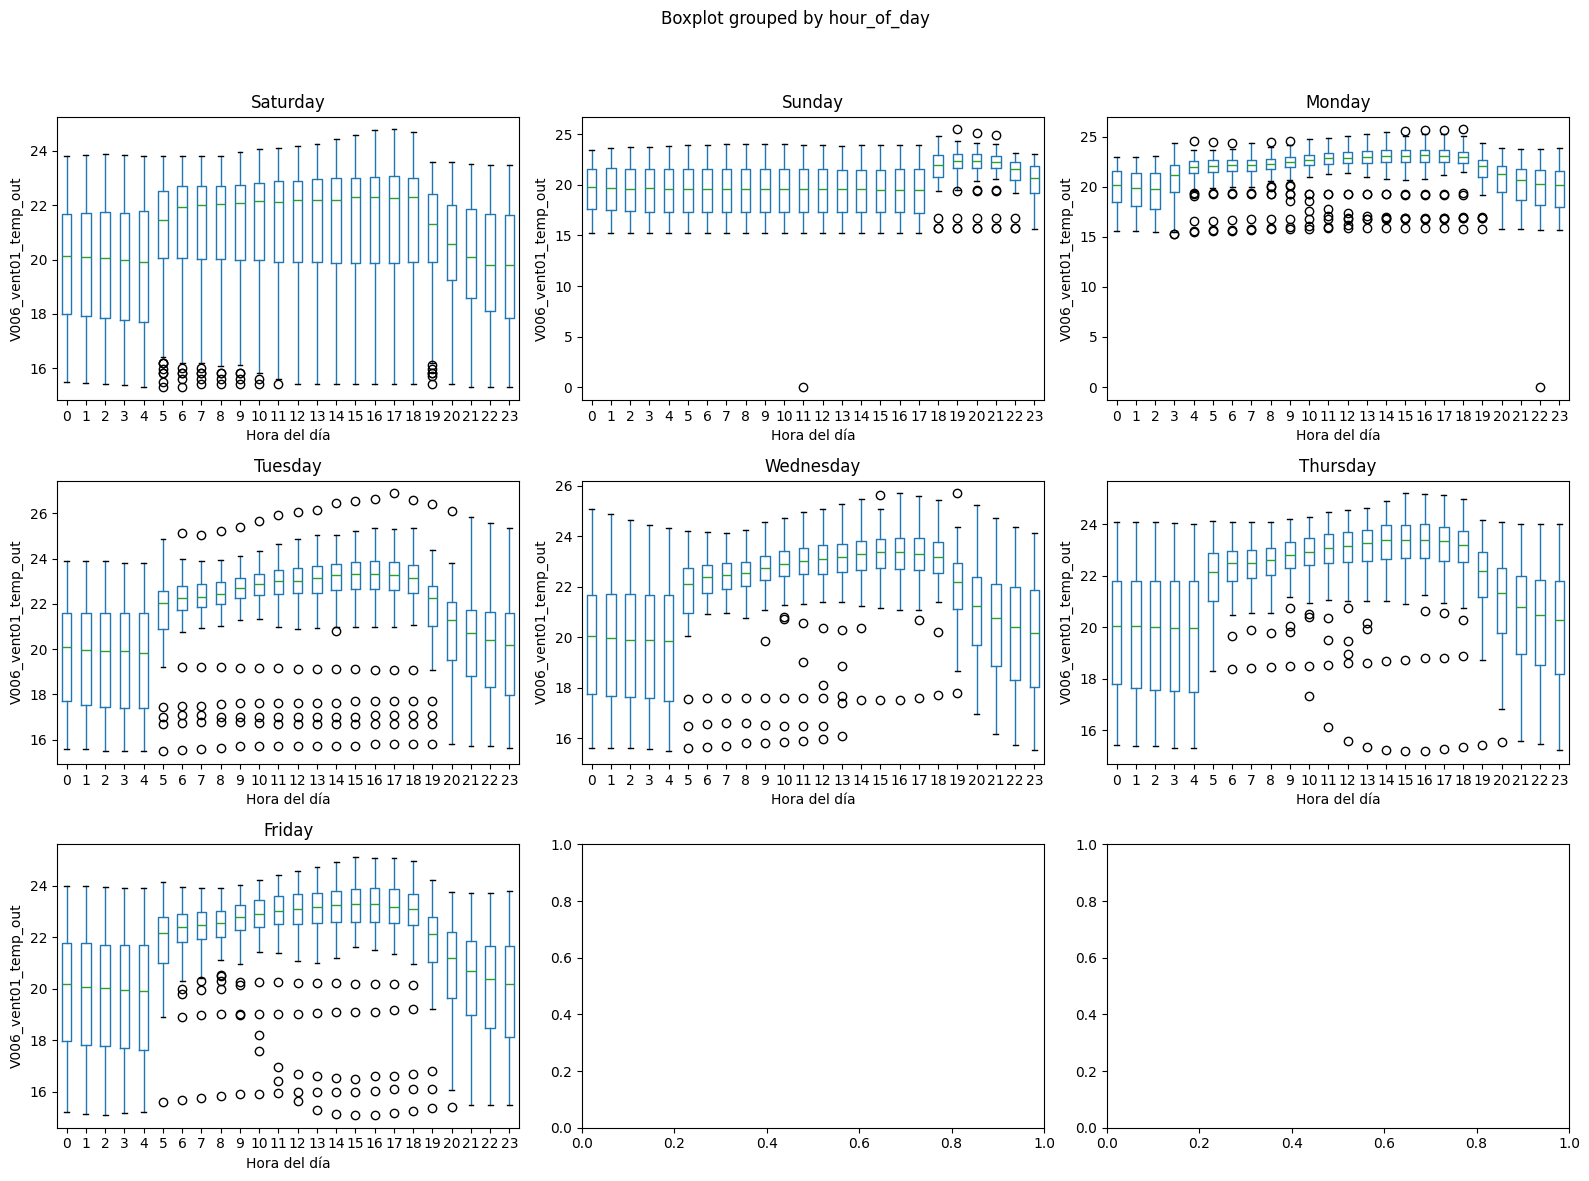

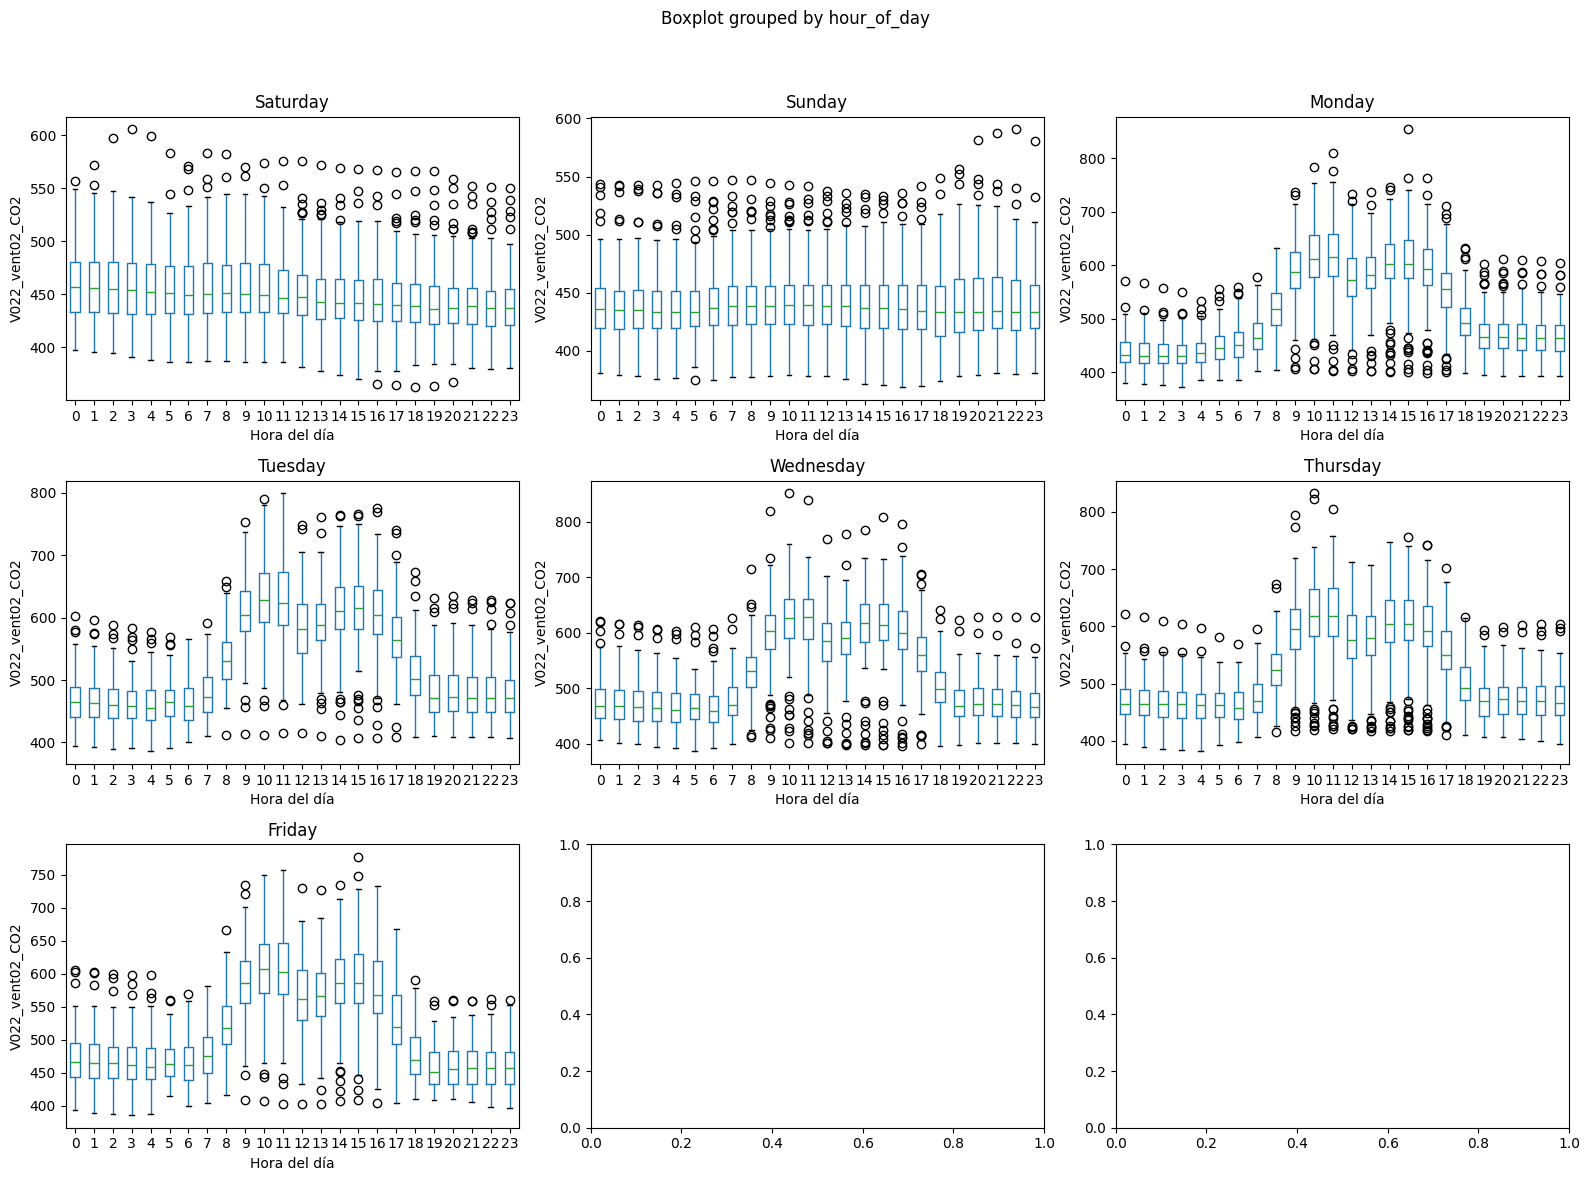

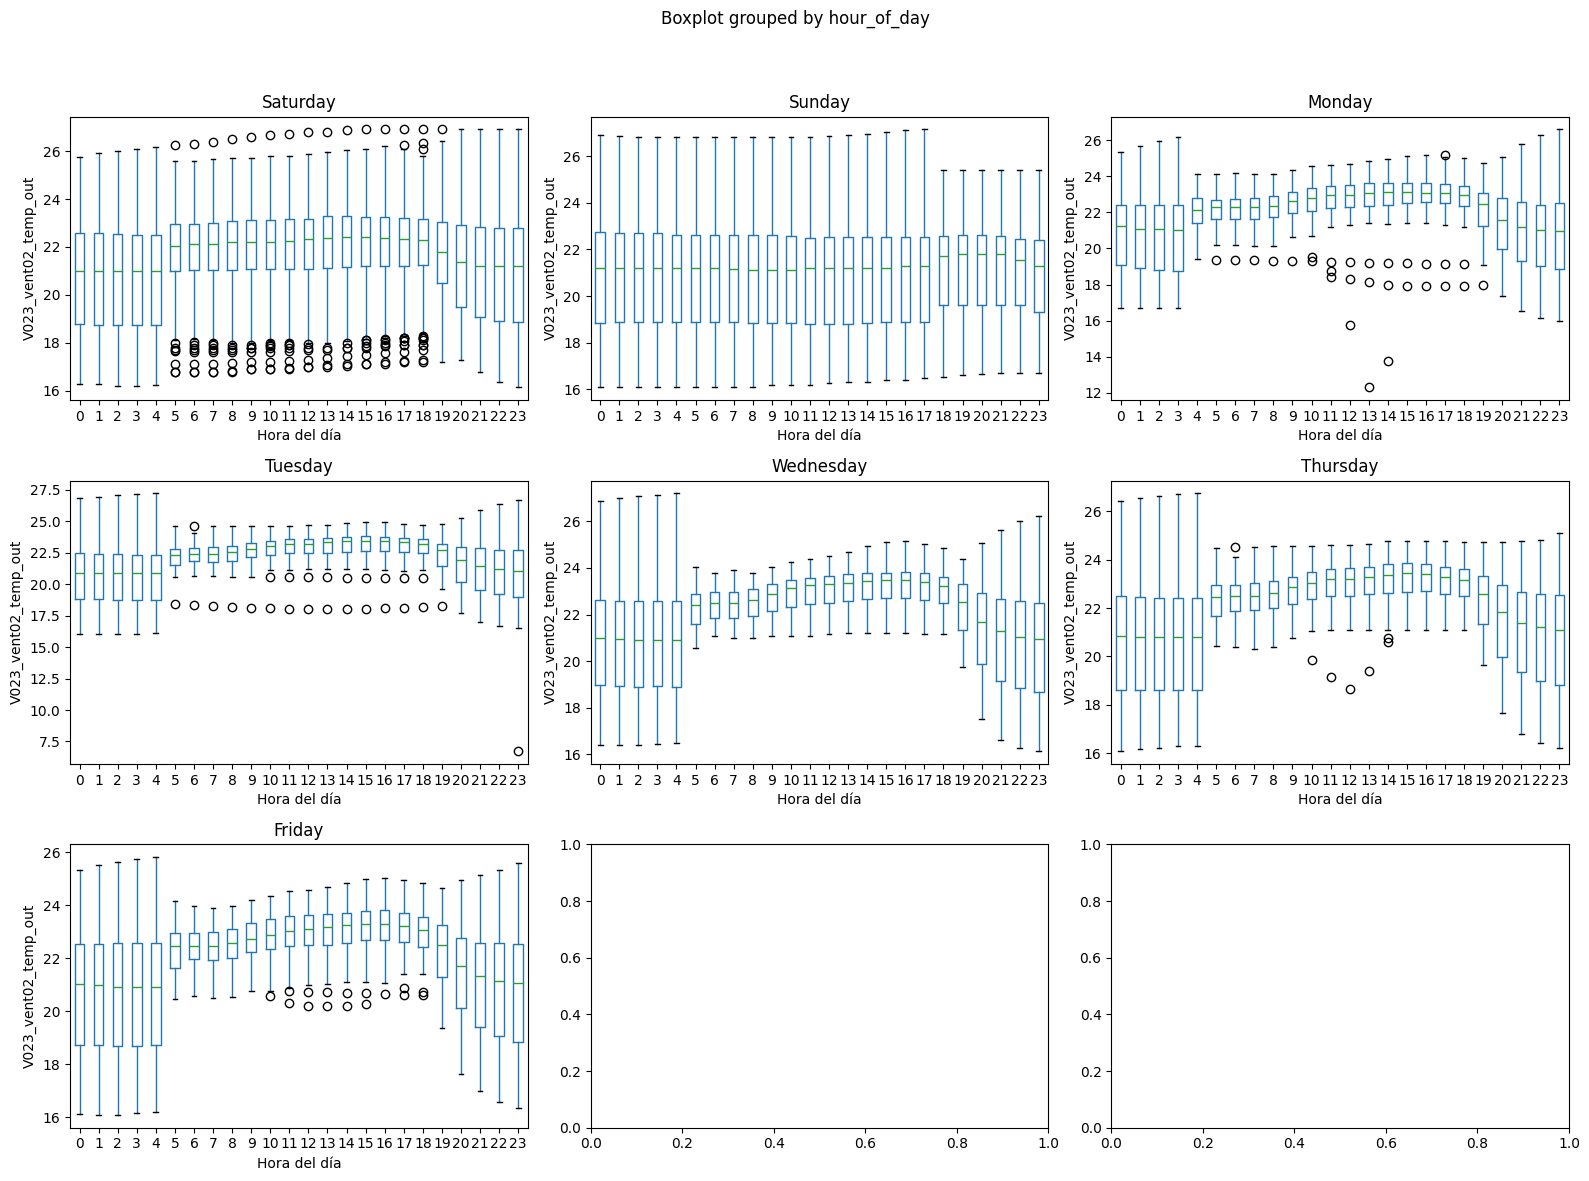

In [6]:
# Para cada variable, crear un gráfico con los subgráficos de cada día de la semana
for variable in variables:
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))  # Crear una cuadrícula de subplots de 3x3 para mejor visualización
    fig.suptitle(f'{variable} - Diagrama de caja por día de la semana', fontsize=16)

    # Recorremos cada día de la semana y asignamos el subplot correspondiente
    for i, day in enumerate(days_of_week):
        ax = axes[i // 3, i % 3]  # Seleccionar la posición adecuada en la cuadrícula
        day_data = df[df['day_of_week'] == day]

        # Solo graficar si hay datos para ese día
        if not day_data.empty:
            day_data.boxplot(column=variable, by='hour_of_day', ax=ax, grid=False)
            ax.set_title(day)
            ax.set_xlabel('Hora del día')
            ax.set_ylabel(variable)
        else:
            ax.set_visible(False)  # Ocultar subplots vacíos

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el espaciado para que el título no se superponga
    plt.show()

### Generacion de grafico para analisis multivariado

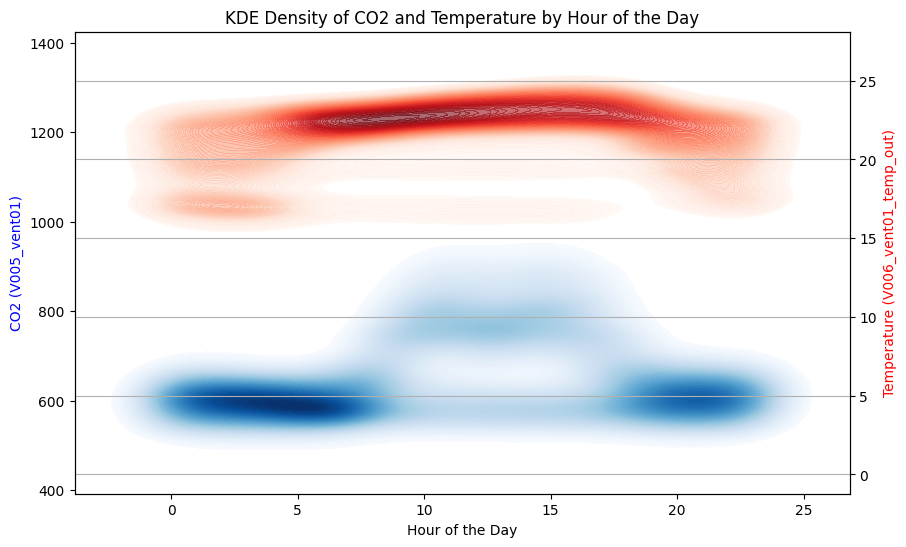

In [41]:
# Gráfico KDE de densidad con dos ejes: uno para CO2 y otro para la temperatura
fig, ax1 = plt.subplots(figsize=(10, 6))

# KDE de densidad para CO2 en función de la hora del día
sns.kdeplot(
    x=df['hour_of_day'],
    y=df['V005_vent01_CO2'],
    fill=True,
    cmap='Blues',
    thresh=0.05,
    levels=100,
    ax=ax1
)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('CO2 (V005_vent01)', color='blue')

# Crear el segundo eje para la temperatura
ax2 = ax1.twinx()

# Añadir la temperatura en un gráfico KDE en el segundo eje
sns.kdeplot(
    x=df['hour_of_day'],
    y=df['V006_vent01_temp_out'],
    fill=True,
    cmap='Reds',
    thresh=0.05,
    levels=100,
    alpha=0.6,
    ax=ax2
)
ax2.set_ylabel('Temperature (V006_vent01_temp_out)', color='red')

plt.title('KDE Density of CO2 and Temperature by Hour of the Day')
plt.grid(True)
plt.show()

### Grafico para analisis multivariado sobre la misma escala visualizando las temperaturas como escala de color

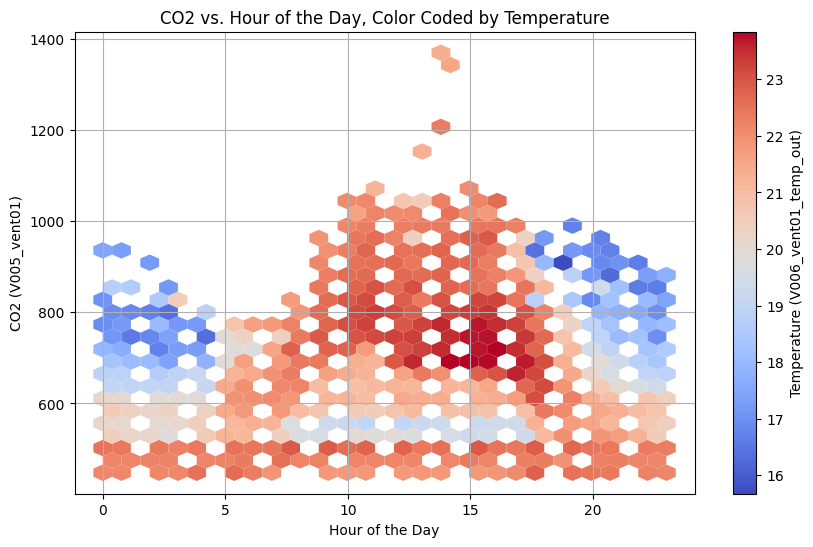

In [39]:
# Crear el gráfico hexbin que muestra CO2 y temperatura según la hora del día
plt.figure(figsize=(10, 6))

# Gráfico hexbin para CO2 y temperatura en función de la hora del día
plt.hexbin(df['hour_of_day'], df['V005_vent01_CO2'], C=df['V006_vent01_temp_out'], gridsize=30, cmap='coolwarm', mincnt=1, edgecolors='none')
plt.colorbar(label='Temperature (V006_vent01_temp_out)')

plt.title('CO2 vs. Hour of the Day, Color Coded by Temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('CO2 (V005_vent01)')
plt.grid(True)
plt.show()

### Analisis multivariado para la identificacion de anomalias

In [16]:
# Seleccionar las dos parejas de variables para el análisis
X = df[['V005_vent01_CO2', 'V006_vent01_temp_out', 'V022_vent02_CO2', 'V023_vent02_temp_out']].dropna()


In [17]:

# Escalar los datos (normalización) para PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
# Aplicar PCA para reducir las dimensiones a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [61]:
# Imprimir la varianza explicada por cada componente
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)
# Varianza total explicada por las primeras 2 componentes
print("\nVarianza total explicada por las primeras 2 componentes:")
print(sum(pca.explained_variance_ratio_))

Varianza explicada por cada componente:
[0.60039018 0.34336941]

Varianza total explicada por las primeras 2 componentes:
0.9437595894764209


In [72]:
# Ajustar el modelo GMM (Gaussian Mixture Model) para detectar clusters
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

In [73]:
# Encontrar las anomalías basadas en la probabilidad (baja probabilidad indica anomalías)
probs = gmm.predict_proba(X_pca)
anomalies = np.where(np.max(probs, axis=1) < 0.8)  # Umbral de probabilidad baja para detectar anomalías


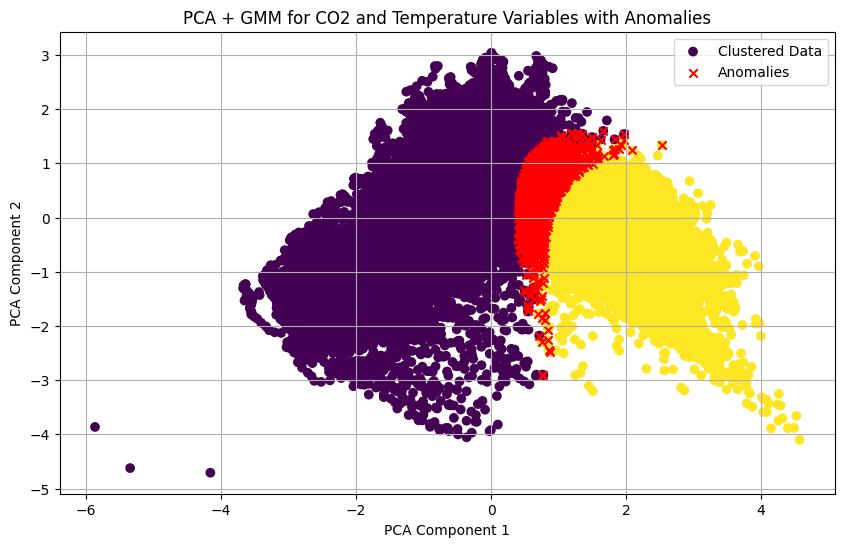

In [74]:

# Visualizar los resultados y las anomalías
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', label='Clustered Data')
plt.scatter(X_pca[anomalies][:, 0], X_pca[anomalies][:, 1], color='red', label='Anomalies', marker='x')
plt.title('PCA + GMM for CO2 and Temperature Variables with Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Supongamos que ya tienes los índices de las anomalías desde GMM (lo mismo que antes)
anomalies = np.where(np.max(probs, axis=1) < 0.8)  # Índices de anomalías

# Extraer las anomalías del conjunto de datos original (sin escalar)
anomalous_data = df.iloc[anomalies]

# Mostrar las anomalías
print("Datos originales que son anomalías:")
print(anomalous_data)

Datos originales que son anomalías:
                timestamp  V005_vent01_CO2  V022_vent02_CO2  \
56    2012-06-25 09:00:00       610.941931       530.025474   
59    2012-06-25 12:00:00       654.040184       520.897176   
60    2012-06-25 13:00:00       644.013681       539.108093   
63    2012-06-25 16:00:00       635.936475       532.453461   
83    2012-06-26 12:00:00       614.256935       508.529953   
...                   ...              ...              ...   
25875 2015-06-06 05:00:00       616.821806       503.300229   
25876 2015-06-06 06:00:00       616.121738       505.115699   
25877 2015-06-06 07:00:00       620.377055       507.346998   
25924 2015-06-08 06:00:00       613.049606       487.869085   
25936 2015-06-08 18:00:00       647.124708       572.968783   

       V006_vent01_temp_out  V023_vent02_temp_out  hour_of_day day_of_week  
56                23.434587             23.216500            9      Monday  
59                23.700000             23.600000    

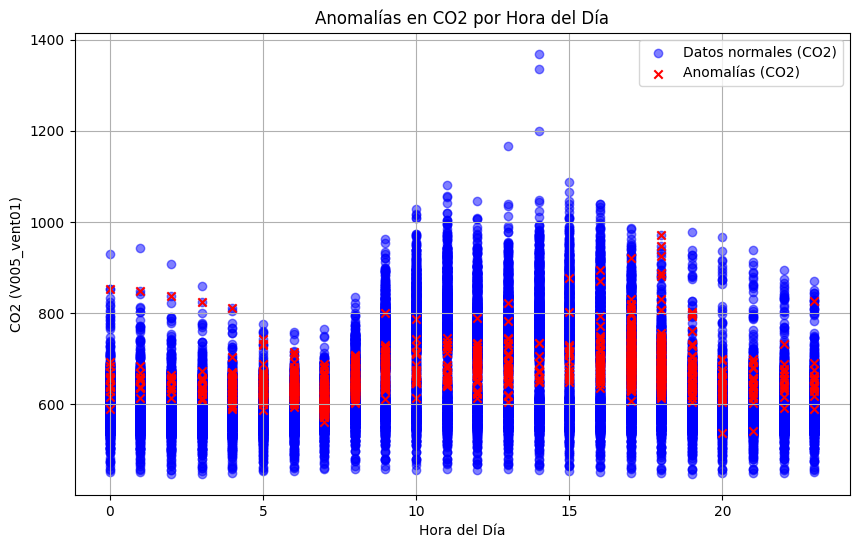

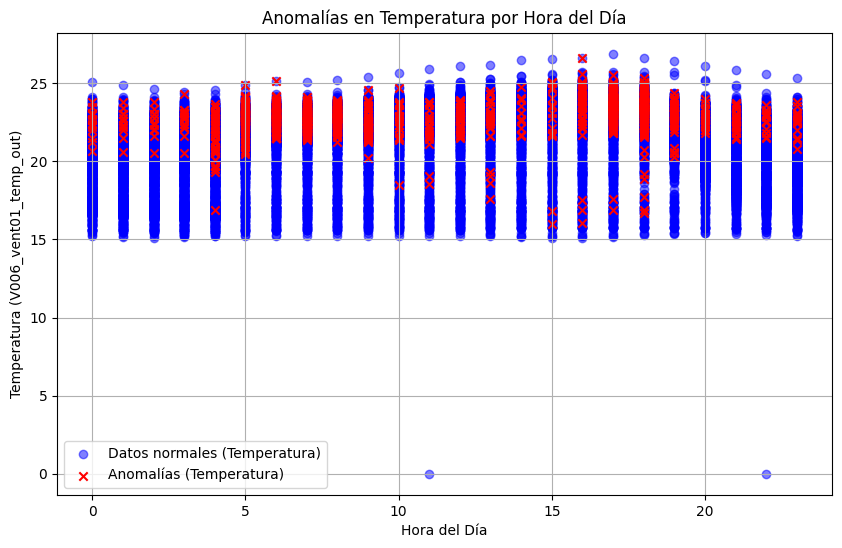

In [76]:
# Extraer las anomalías del dataset original (sin escalar)
anomalous_data = df.iloc[anomalies]

# Crear el gráfico para CO2
plt.figure(figsize=(10, 6))
plt.scatter(df['hour_of_day'], df['V005_vent01_CO2'], label='Datos normales (CO2)', alpha=0.5, color='blue')
plt.scatter(anomalous_data['hour_of_day'], anomalous_data['V005_vent01_CO2'], label='Anomalías (CO2)', color='red', marker='x')
plt.title('Anomalías en CO2 por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('CO2 (V005_vent01)')
plt.legend()
plt.grid(True)
plt.show()

# Crear el gráfico para temperatura
plt.figure(figsize=(10, 6))
plt.scatter(df['hour_of_day'], df['V006_vent01_temp_out'], label='Datos normales (Temperatura)', alpha=0.5, color='blue')
plt.scatter(anomalous_data['hour_of_day'], anomalous_data['V006_vent01_temp_out'], label='Anomalías (Temperatura)', color='red', marker='x')
plt.title('Anomalías en Temperatura por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Temperatura (V006_vent01_temp_out)')
plt.legend()
plt.grid(True)
plt.show()